## Import Modules

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the Dataset

In [2]:
df = pd.read_csv('/kaggle/input/techno/train.csv')
val_df = pd.read_csv('/kaggle/input/techno/validation.csv')
val_df.drop("lang", axis="columns", inplace=True)

## Exploratory Data Analysis

<Axes: >

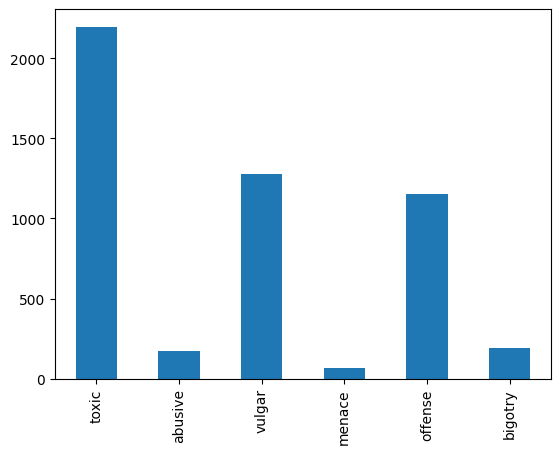

In [3]:
x = df.iloc[:, 2:].sum() # take only label columns
x.plot(kind="bar")

In [4]:
rowsums = df.iloc[:, 2:].sum(axis=1) # take label columns and sum it column wise
rowsums

0        0
1        0
2        0
3        2
4        0
        ..
23468    2
23469    2
23470    0
23471    0
23472    2
Length: 23473, dtype: int64

In [5]:
no_label_count = 0

for i, count in rowsums.items():
    if count==0:
        no_label_count += 1
        
print('Total number of feedbacks:', len(df))
print('Total number of feedbacks without labels:', no_label_count)
print('Total labels:', x.sum())

Total number of feedbacks: 23473
Total number of feedbacks without labels: 21160
Total labels: 5056


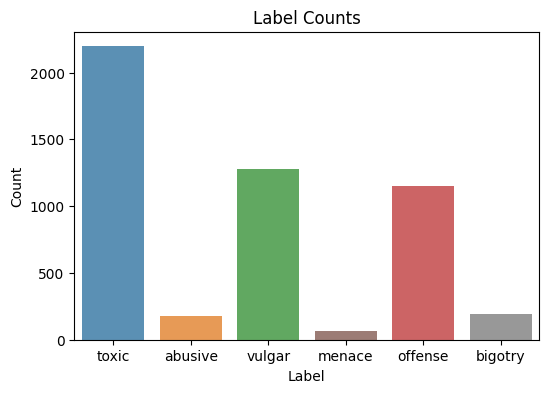

In [6]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Label Counts')
plt.ylabel('Count')
plt.xlabel('Label')

plt.show()

In [7]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing)

Missing values:
 id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
dtype: int64


In [8]:
df['len'] = df['feedback_text'].str.len()

In [9]:
df['len'].describe()

count    23473.000000
mean       402.029736
std        617.165581
min          6.000000
25%         94.000000
50%        204.000000
75%        437.000000
max       5000.000000
Name: len, dtype: float64

<Axes: ylabel='Density'>

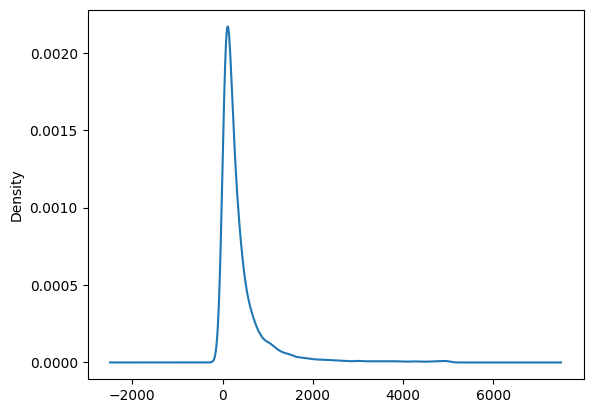

In [10]:
df['feedback_text'].str.len().plot(kind="kde")

## Data Preprocessing

In [11]:
df = df.drop(columns=['id', 'len'], axis=1)
df.head()

,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


In [12]:
# remove stopwords
stop_words = list(stopwords.words("english"))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return " ".join(no_stopword_text)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

# stemming
stemmer = SnowballStemmer('english')
def stemming(sentence):
    stemmed_sentence = ""
    for word in sentence.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word + " "
        
    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

In [13]:
# preprocess the comment
df['feedback_text'] = df['feedback_text'].apply(lambda x: remove_stopwords(x))
df['feedback_text'] = df['feedback_text'].apply(lambda x: clean_text(x))
df['feedback_text'] = df['feedback_text'].apply(lambda x: stemming(x))
df.head()

,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,sound good let know done i will start pr,0,0,0,0,0,0
1,i say someth actual confirm anyth put articl p...,0,0,0,0,0,0
2,agustina barriento modelo de piñeiro juán cruz...,0,0,0,0,0,0
3,fyi i enjoy lick stranger scrotal sack especi ...,1,0,1,0,0,0
4,how get site mani penguin ask question it simp...,0,0,0,0,0,0


In [14]:
# split input and output
X = df['feedback_text']
y = df.drop(columns=['feedback_text'], axis=1)

In [15]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
def run_pipeline(pipeline, X_train, X_test, y_train, y_test):
    # train model
    pipeline.fit(X_train, y_train)
    # predict from model
    predictions = pipeline.predict(X_test)
    pred_probs = pipeline.predict_proba(X_test)
    # print metrics
    print('roc_auc:', roc_auc_score(y_test, pred_probs))
    print('accuracy:', accuracy_score(y_test, predictions))
    print('classification report')
    print(classification_report(y_test, predictions, target_names=y_train.columns))

In [17]:
NB_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
])

LR_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
])

In [18]:
run_pipeline(NB_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.8184173170907623
accuracy: 0.9024494142705005
classification report
              precision    recall  f1-score   support

       toxic       0.93      0.06      0.12       431
     abusive       0.00      0.00      0.00        32
      vulgar       0.83      0.04      0.08       249
      menace       0.00      0.00      0.00        20
     offense       0.33      0.00      0.01       230
     bigotry       0.00      0.00      0.00        38

   micro avg       0.86      0.04      0.07      1000
   macro avg       0.35      0.02      0.03      1000
weighted avg       0.69      0.04      0.07      1000
 samples avg       0.01      0.00      0.00      1000



In [19]:
run_pipeline(LR_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.9635711433381272
accuracy: 0.9122470713525027
classification report
              precision    recall  f1-score   support

       toxic       0.91      0.42      0.58       431
     abusive       0.36      0.12      0.19        32
      vulgar       0.90      0.46      0.61       249
      menace       0.00      0.00      0.00        20
     offense       0.83      0.34      0.49       230
     bigotry       0.25      0.03      0.05        38

   micro avg       0.87      0.38      0.53      1000
   macro avg       0.54      0.23      0.32      1000
weighted avg       0.83      0.38      0.52      1000
 samples avg       0.04      0.03      0.03      1000



# Tuning

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

def plot_solver_iter(X_og, y_og):
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
        X_og, 
        y_og,
        test_size=0.15,
        shuffle=True,
    )

    # Initialize empty dataframes to store the results
    default_results_df = pd.DataFrame(columns=["Model", "Target", "Accuracy", "Precision", "Recall", "F1 Score"])
    tuned_results_df = pd.DataFrame(columns=["Model", "Target", "Parameters", "Accuracy", "Precision", "Recall", "F1 Score"])

    # Define models and their hyperparameters
    models = {
        "LogisticRegression": [Pipeline([
            ('tfidf', TfidfVectorizer(stop_words='english')),
            ('nb_model', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
        ])]
    }

    tuned_models = {
        "LogisticRegression": [
            {"solver": 'lbfgs'}, 
            {"solver": 'liblinear'}, 
            {"solver": 'newton-cg'}, 
            {"solver": 'newton-cholesky'}, 
            {"solver": 'sag'}, 
            {"solver": 'saga'},
            {"max_iter": 50}, 
            {"max_iter": 100},
            {"max_iter": 150}, 
            {"max_iter": 200}, 
            {"max_iter": 250},
            {"max_iter": 300}, 
        ]
    }

    # Loop through targets
    for target in [1]:
        print(f"========{target}=========")
        
        # Benchmark Default Models (no parameters)
        for model_name, model_list in models.items():
            for model in model_list:
                X_train = X_train_i
                y_train = y_train_i
                X_test = X_test_i
                y_test = y_test_i

                # Train the model
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, average='weighted')
                recall = recall_score(y_test, y_pred, average='weighted')
                f1 = f1_score(y_test, y_pred, average='weighted')
                
                # Create a new result row
                default_result = pd.DataFrame({
                    "Model": [model_name], 
                    "Accuracy": [accuracy], 
                    "Precision": [precision], 
                    "Recall": [recall], 
                    "F1 Score": [f1]
                })
                
                # Concatenate the new row to the DataFrame
                default_results_df = pd.concat([default_results_df, default_result], ignore_index=True)

                # Print results
                print(f"Model: {model_name} - Default")
                print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
                print(classification_report(y_test, y_pred, target_names=y_train.columns))
        
        # Benchmark Tuned Models (with hyperparameters)
        for model_name, hyperparameter_list in tuned_models.items():
            for params in hyperparameter_list:
                models[model_name][0][1].estimator.__class__(**params)  # Create a model with the specific hyperparameters
                model = models[model_name][0]  
                X_train = X_train_i
                y_train = y_train_i
                X_test = X_test_i
                y_test = y_test_i

                # Train the model
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, average='weighted')
                recall = recall_score(y_test, y_pred, average='weighted')
                f1 = f1_score(y_test, y_pred, average='weighted')
                
                # Create a new result row
                tuned_result = pd.DataFrame({
                    "Model": [model_name], 
                    "Parameters": [params], 
                    "Accuracy": [accuracy], 
                    "Precision": [precision], 
                    "Recall": [recall], 
                    "F1 Score": [f1]
                })
                
                # Concatenate the new row to the DataFrame
                tuned_results_df = pd.concat([tuned_results_df, tuned_result], ignore_index=True)

                # Print results
                print(f"Model: {model_name} - Tuned with {params}")
                print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
                print(classification_report(y_test, y_pred, target_names=y_train.columns))

    return models["LogisticRegression"][0], default_results_df, tuned_results_df

    # You can also plot the results if needed, e.g., plotting accuracy vs model or hyperparameter, etc.
models, default, tuned = plot_solver_iter(X_train, y_train)

========1=========
Model: LogisticRegression - Default
Accuracy: 0.9109, Precision: 0.8778, Recall: 0.3593, F1: 0.5040
              precision    recall  f1-score   support

       toxic       0.94      0.39      0.55       271
     abusive       1.00      0.11      0.20        18
      vulgar       0.91      0.45      0.60       150
      menace       0.00      0.00      0.00         9
     offense       0.84      0.31      0.46       131
     bigotry       0.50      0.04      0.07        25

   micro avg       0.90      0.36      0.51       604
   macro avg       0.70      0.22      0.31       604
weighted avg       0.88      0.36      0.50       604
 samples avg       0.04      0.03      0.03       604

Model: LogisticRegression - Tuned with {'solver': 'lbfgs'}
Accuracy: 0.9109, Precision: 0.8778, Recall: 0.3593, F1: 0.5040
              precision    recall  f1-score   support

       toxic       0.94      0.39      0.55       271
     abusive       1.00      0.11      0.20        1

## Test Prediction

In [21]:
y_train.nunique()

toxic      2
abusive    2
vulgar     2
menace     2
offense    2
bigotry    2
dtype: int64

In [22]:
labels = y_train.columns.values
labels

array(['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry'],
      dtype=object)

In [23]:
sentence = 'hello dick wikipedia fuckwhit ban'
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))

         toxic     1
       abusive     0
        vulgar     1
        menace     0
       offense     0
       bigotry     0


## ROC Curve

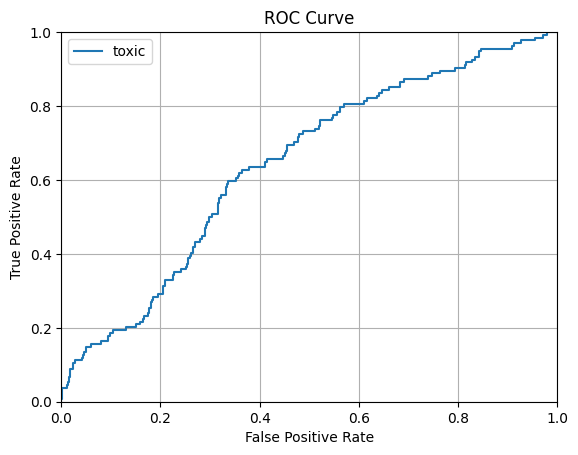

In [24]:
def plot_roc_curve(test_labels, predict_prob):
    fpr, tpr, thresholds = roc_curve(test_labels, predict_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(labels)
    
def plot_pipeline_roc_curve(pipeline, X_train, X_test, y_train, y_test):
    # pipeline.fit(X_train, y_train)
    # pred_probs = pipeline.predict(X_test)[:, 1]
    # plot_roc_curve(y_test, pred_probs)
    for label in ['toxic']:
        pipeline.fit(X_train, y_train[label])
        pred_probs = pipeline.predict_proba(X_test)[:, 1]
        plot_roc_curve(y_test[label], pred_probs)

eval_df = pd.read_csv("/kaggle/input/techno/validation.csv")
eval_df.drop(['id', "lang"], axis="columns", inplace=True)


plot_pipeline_roc_curve(LR_pipeline, X_train, eval_df.drop('toxic', axis="columns")['feedback_text'], y_train, eval_df)

In [25]:
test = pd.read_csv("/kaggle/input/techno/test.csv")


In [26]:
test.loc[0:6000]

,id,content,lang
0,56496,"Bahar merhaba, Şu TV programı için bildiğin gi...",tr
1,18266,"Merhaba, başlık taşıma nedeniyle bir karışıklı...",tr
2,37852,kullanıcı ne mutlu türküm diyene yazmış ta...,tr
3,25075,Quand la plaisanterie sur le synopsis de ce fi...,fr
4,330,Não fosse seu esclarecimento no blog da Anne (...,pt
...,...,...,...
5996,13655,Merhaba. Vikipedi miz 150.000 maddeye ulaştı a...,tr
5997,57160,Ну по сути 2 раза. К тому же там претензии из...,ru
5998,2322,"Ma asi es lo mismo, dando opcion a las otras d...",es
5999,15179,je dirais bien « va donc espèce de bufon » ma...,fr


In [27]:
test = pd.read_csv("/kaggle/input/techno/test.csv")
test.drop(['id', "lang"], axis="columns", inplace=True)
test_labels = pd.read_csv("/kaggle/input/techno/test_labels.csv").drop("id", axis="columns")

for label in ['toxic']:
    pred_probs = LR_pipeline.predict(test["content"].loc[0:5999])
    print(classification_report(test_labels, pred_probs))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4637
           1       0.12      0.00      0.00      1363

    accuracy                           0.77      6000
   macro avg       0.45      0.50      0.44      6000
weighted avg       0.63      0.77      0.67      6000

